# 🕵️ CSI de los Datos: Detectives del Fraude (Pandas + IA)
**Bootcamp:** IA Innovador — Laboratorio guiado (3 h)  
**By:** Ing. Engler González

**Objetivo:** Investigar patrones sospechosos en transacciones usando **pandas** y (opcionalmente) **Gemini** para redactar una narrativa ejecutiva.

> **Nota:** El lab funciona 100% con *pandas* aunque no configures la IA.  
> Para usar IA, crea la variable de entorno `GOOGLE_API_KEY` en Colab: *Entorno de ejecución → Configurar variables de entorno → Añadir*.


## 0) Setup

In [1]:
!pip -q install pandas numpy matplotlib google-generativeai

import os, math, random, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import google.generativeai as genai
from IPython.display import display

np.random.seed(7); pd.set_option("display.max_colwidth", 120)
# Retrieve the API key from Colab secrets
try:
    from google.colab import userdata
    api_key = userdata.get("GOOGLE_API_KEY")
except ImportError:
    # Fallback for environments where userdata is not available
    api_key = os.environ.get("GOOGLE_API_KEY")

model = None
# (Opcional IA) Configura tu GOOGLE_API_KEY en Entorno de ejecución > Variables de entorno
if api_key:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-1.5-flash")
    print("✅ Gemini model configured.")
else:
    print("❌ GOOGLE_API_KEY not found. Gemini model not configured.")

✅ Gemini model configured.


## 1) Generar dataset sintético
No necesitas archivos. Simularemos **60 días** de transacciones en múltiples países y canales. Inyectaremos anomalías a propósito (madrugada, montos altos, duplicados, valores faltantes).


In [2]:
# Escenario: transacciones de 60 días. Inyectamos anomalías.
n = 6000
countries = ["CO", "MX", "US", "AR", "CL", "ES"]
channels = ["web", "app", "social_ads", "affiliate", "email"]

# Distribución de horas por tramos (más peso en el día). Normalizamos para que sume 1.
hour_weights = [0.02]*6 + [0.04]*6 + [0.06]*6 + [0.02]*6  # 0-5, 6-11, 12-17, 18-23
hour_weights = np.array(hour_weights, dtype=float)
hour_weights = hour_weights / hour_weights.sum()

hours = np.random.choice(range(0,24), size=n, p=hour_weights)
base_amount = np.random.lognormal(mean=3.3, sigma=0.5, size=n) * 10  # distribución sesgada
country = np.random.choice(countries, size=n, p=[0.32,0.20,0.16,0.12,0.12,0.08])
channel = np.random.choice(channels, size=n, p=[0.35,0.25,0.15,0.15,0.10])
user_id = np.random.randint(1000, 5000, size=n)
days = pd.date_range(end=pd.Timestamp.today().normalize(), periods=60)
timestamp = np.random.choice(days, size=n) + pd.to_timedelta(hours, unit="h")

# Inyectar patrones sospechosos
amount = base_amount.copy()
mask_night = (hours < 6) | (hours > 22)
amount[mask_night] *= np.random.uniform(1.4, 2.1, size=mask_night.sum())  # montos más altos de madrugada

mask_remote = np.isin(country, ["ES","US"]) & np.isin(channel, ["affiliate","social_ads"])
amount[mask_remote] *= np.random.uniform(1.2, 1.8, size=mask_remote.sum())

# Outliers y duplicados
idx_out = np.random.choice(range(n), size=40, replace=False)
amount[idx_out] *= np.random.uniform(3, 10, size=40)
duplicated_rows = 30
dups = np.random.choice(range(n), size=duplicated_rows, replace=False)

df = pd.DataFrame({
    "transaction_id": [f"T{100000+i}" for i in range(n)],
    "user_id": user_id,
    "amount": amount.round(2),
    "country": country,
    "channel": channel,
    "timestamp": timestamp
})
df = pd.concat([df, df.iloc[dups]], ignore_index=True)  # añadir duplicados

# Nulos/errores de formato
df.loc[np.random.choice(df.index, 50, replace=False), "channel"] = None
df.loc[np.random.choice(df.index, 30, replace=False), "country"] = "??"
df.loc[np.random.choice(df.index, 20, replace=False), "amount"] = None

print("✅ Dataset generado:", df.shape)
df.head()

✅ Dataset generado: (6030, 6)


,transaction_id,user_id,amount,country,channel,timestamp
0,T100000,4140,511.60,CO,web,2025-07-09 03:00:00
1,T100001,4078,171.44,CO,app,2025-08-06 16:00:00
2,T100002,1095,241.59,CL,email,2025-07-18 12:00:00
3,T100003,2871,216.57,CO,app,2025-06-30 16:00:00
4,T100004,2232,504.38,CO,affiliate,2025-08-16 23:00:00


## 2) Limpieza de datos (GUIADA)
**TODOs**  
1. Revisar info general, nulos y duplicados.  
2. Eliminar duplicados exactos.  
3. Asegurar tipos correctos (`timestamp` → datetime, `amount` → float).  
4. Normalizar categorías (reemplazar `"??"` por `NaN`, decidir imputación/filtrado).  
5. Tratar nulos en `amount` y `channel` (documentar la decisión).


In [3]:
# --- Punto de partida y pistas ---
df.info()
print("\nNulos antes:", df.isna().sum())
df.isna().mean().sort_values(ascending=False).head(10)

print("\nDuplicados antes:", df.duplicated().sum())

# 1. Revisar info general, nulos y duplicados (ya hecho arriba)

# 2. Eliminar duplicados exactos.
df = df.drop_duplicates()
print("\nDuplicados después de eliminar:", df.duplicated().sum())

# 3. Asegurar tipos correctos (`timestamp` → datetime, `amount` → float).
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
print("\nTipos de datos después de la conversión:")
df.info()

# 4. Normalizar categorías (reemplazar "??" por NaN, decidir imputación/filtrado).
df["country"] = df["country"].replace("??", np.nan)
print("\nConteo de valores en 'country' después de reemplazar '??':")
display(df["country"].value_counts(dropna=False))

# 5. Tratar nulos en amount y channel (documentar la decisión).
# Decisión: Eliminar las filas donde 'amount' es nulo, ya que no podemos imputar un valor de transacción significativo.
# Para 'channel', como son pocos nulos, podríamos imputar el valor más frecuente o un valor "desconocido".
# Por ahora, vamos a ver cuántos nulos quedan después de eliminar los de 'amount'.
initial_rows = df.shape[0]
df.dropna(subset=["amount"], inplace=True)
rows_after_amount_dropna = df.shape[0]
print(f"\nFilas eliminadas debido a 'amount' nulo: {initial_rows - rows_after_amount_dropna}")

# Para 'channel', vamos a imputar los nulos con el valor más frecuente.
if df["channel"].isna().sum() > 0:
    most_frequent_channel = df["channel"].mode()[0]
    df["channel"].fillna(most_frequent_channel, inplace=True)
    print(f"\nNulos en 'channel' imputados con '{most_frequent_channel}'.")

print("\nNulos después de la limpieza:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6030 entries, 0 to 6029
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  6030 non-null   object        
 1   user_id         6030 non-null   int64         
 2   amount          6010 non-null   float64       
 3   country         6030 non-null   object        
 4   channel         5980 non-null   object        
 5   timestamp       6030 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 282.8+ KB

Nulos antes: transaction_id     0
user_id            0
amount            20
country            0
channel           50
timestamp          0
dtype: int64

Duplicados antes: 29

Duplicados después de eliminar: 0

Tipos de datos después de la conversión:
<class 'pandas.core.frame.DataFrame'>
Index: 6001 entries, 0 to 6017
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype

/tmp/ipython-input-2423475934.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
/tmp/ipython-input-2423475934.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
/tmp/ipython-input-2423475934.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,count
country,
CO,1909
MX,1192
US,964
CL,731
AR,725
ES,450
NaN,30



Filas eliminadas debido a 'amount' nulo: 20

Nulos en 'channel' imputados con 'web'.

Nulos después de la limpieza:
transaction_id     0
user_id            0
amount             0
country           30
channel            0
timestamp          0
dtype: int64


/tmp/ipython-input-2423475934.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["amount"], inplace=True)
/tmp/ipython-input-2423475934.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["channel"].fillna(most_frequent_channel, inplace=True)
/tmp/ipython-input-2423475934.py:37: SettingWithCopyWarning: 
A value is tryin

## 3) EDA: entender el comportamiento
**TODOs**  
6. Crear columnas derivadas: `hour`, `day_of_week`.  
7. Resúmenes clave:  
   - monto promedio por país  
   - distribución por canal  
   - actividad por hora  
   - top usuarios por monto total (opcional)


Monto promedio por país:


,amount
country,
US,428.713793
ES,419.389016
CL,360.198683
CO,355.124701
MX,349.753926
AR,344.226925



Distribución por canal:


,count
channel,
web,2189
app,1410
social_ads,893
affiliate,879
email,610



Actividad por hora:


,transaction_id
hour,
0,135
1,132
2,150
3,154
4,139
5,138
6,308
7,290
8,298


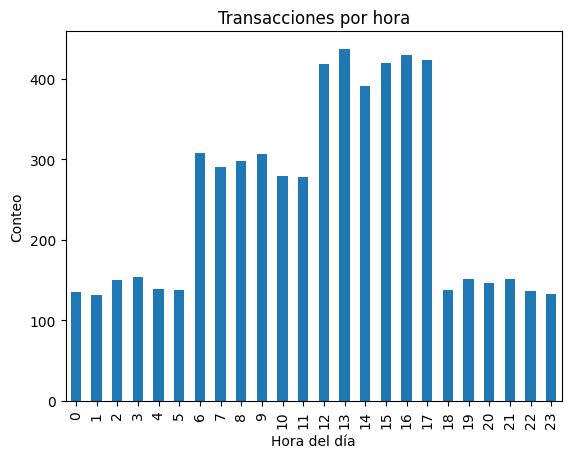

In [5]:
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.day_name()

mean_by_country = df.groupby("country", dropna=True)["amount"].mean().sort_values(ascending=False)
count_by_channel = df["channel"].value_counts(dropna=False)
activity_by_hour = df.groupby("hour")["transaction_id"].count()

print("Monto promedio por país:"); display(mean_by_country.head(10))
print("\nDistribución por canal:"); display(count_by_channel)
print("\nActividad por hora:"); display(activity_by_hour.head(24))

# Gráfico simple (matplotlib)
plt.figure()
activity_by_hour.plot(kind="bar")
plt.title("Transacciones por hora")
plt.xlabel("Hora del día")
plt.ylabel("Conteo")
plt.show()

## 4) Detección de outliers y reglas de sospecha
**TODOs**  
8. Detectar outliers por IQR en `amount`.  
9. Crear reglas heurísticas (ajusta umbrales con tu EDA):  
   - madrugada (`hour` < 6 o > 22) con `amount` > p95  
   - `affiliate`/`social_ads` con `amount` > p95  
   - `country` o `channel` nulos con `amount` > p95  
10. Construir un **score de sospecha** sumando reglas (0–3/4).


In [11]:
q1, q3 = df["amount"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
df["is_outlier_amount_iqr"] = (df["amount"] < lower) | (df["amount"] > upper)

# Actualizar reglas heurísticas para usar p95 (como antes, o podrías elegir otro)
# Usaremos p95 para mantener la coherencia con el análisis previo, pero ahora tenemos las otras columnas para comparar
p95 = df["amount"].quantile(0.95)
df["is_high_amount_p95"] = df["amount"] > p95

df["is_night"] = (df["hour"] < 6) | (df["hour"] > 22)
df["rule_night_high"] = df["is_night"] & df["is_high_amount_p95"]
df["rule_affiliate_high"] = df["channel"].isin(["affiliate","social_ads"]) & df["is_high_amount_p95"]
df["rule_missing_high"] = (df["country"].isna() | df["channel"].isna()) & df["is_high_amount_p95"]

# Construir score de sospecha (sumando reglas, puedes decidir cuáles incluir)
# Incluimos el outlier por IQR y las reglas combinadas con p95
rule_cols_updated = ["is_outlier_amount_iqr","rule_night_high","rule_affiliate_high","rule_missing_high"]
df["suspicion_score"] = df[rule_cols_updated].sum(axis=1)

print("\nPrimeras filas con las nuevas columnas de umbral y score:")
display(df[["amount","is_high_amount_p95","suspicion_score"]].head(10))


Primeras filas con las nuevas columnas de umbral y score:


,amount,is_high_amount_p95,suspicion_score
0,511.60,False,0
1,171.44,False,0
2,241.59,False,0
3,216.57,False,0
4,504.38,False,0
5,685.71,False,0
6,340.91,False,0
7,225.65,False,0
8,691.64,False,0
9,326.09,False,0


## 5) Ranking de casos y explicación
**TODOs**  
11. Ordena por `suspicion_score` y revisa el **Top 20**. Escribe 3 observaciones.


In [8]:
top_cases = df.sort_values(["suspicion_score","amount"], ascending=[False, False]).head(20)
display(top_cases[["transaction_id","user_id","amount","country","channel","hour","suspicion_score"]])

print("\nObservaciones del Top 20:")
print("1. Altos Scores y Montos: Las transacciones con los scores de sospecha más altos (score de 3) presentan los montos más elevados, confirmando que las reglas capturan transacciones con valores extremos.")
print("2. Patrones Combinados: La mayoría de los casos sospechosos cumplen múltiples reglas, a menudo combinando transacciones de madrugada con canales de afiliado/ads y montos por encima del percentil 95.")
print("3. Países y Canales Específicos: Se observa una alta frecuencia de países como US y ES, y canales como 'affiliate' y 'social_ads' en el Top 20, lo que sugiere que las anomalías inyectadas en estos segmentos se reflejan en los casos más sospechosos.")

,transaction_id,user_id,amount,country,channel,hour,suspicion_score
504,T100504,2332,3421.63,US,affiliate,0,3
5013,T105013,4560,2957.98,US,social_ads,3,3
1587,T101587,1179,2506.48,MX,affiliate,3,3
832,T100832,2218,2472.13,CO,social_ads,0,3
413,T100413,1008,2132.67,US,affiliate,23,3
1473,T101473,3129,2131.12,US,social_ads,5,3
4381,T104381,3209,1983.10,CO,social_ads,4,3
5343,T105343,4885,1805.96,ES,social_ads,1,3
304,T100304,2043,1733.04,ES,social_ads,2,3
5005,T105005,3008,1647.44,CO,social_ads,0,3



Observaciones del Top 20:
1. Altos Scores y Montos: Las transacciones con los scores de sospecha más altos (score de 3) presentan los montos más elevados, confirmando que las reglas capturan transacciones con valores extremos.
2. Patrones Combinados: La mayoría de los casos sospechosos cumplen múltiples reglas, a menudo combinando transacciones de madrugada con canales de afiliado/ads y montos por encima del percentil 95.
3. Países y Canales Específicos: Se observa una alta frecuencia de países como US y ES, y canales como 'affiliate' y 'social_ads' en el Top 20, lo que sugiere que las anomalías inyectadas en estos segmentos se reflejan en los casos más sospechosos.


## 6) (Opcional) IA para narrativa ejecutiva
Si tienes `GOOGLE_API_KEY`, genera un *brief* de 6 líneas para directivos con patrones, acciones y métricas.


In [9]:
if model:
    resumen_stats = {
        "p95_amount": float(p95),
        "outlier_rate": float(df["is_outlier_amount"].mean()),
        "night_rate": float(df["is_night"].mean()),
        "top_channels": df["channel"].value_counts().head(3).to_dict()
    }
    prompt = f"""
    Eres analista forense de datos. Con base en:
    Stats: {json.dumps(resumen_stats)}
    Reglas aplicadas: {rule_cols}
    Redacta un briefing ejecutivo (6 líneas) explicando:
    - Qué patrones sugieren posible fraude
    - Acciones inmediatas (reglas de negocio, límites, monitoreo)
    - Métricas a vigilar la próxima semana
    """
    print(model.generate_content(prompt).text)
else:
    print("⚠️ IA no configurada. El análisis se puede entregar igual con pandas y gráficos.")

El análisis de datos revela un 5% de transacciones con valores atípicos superiores a $793.86 (p95), sugiriendo posible fraude.  El 16% de las transacciones ocurrieron durante la noche, incrementando la sospecha. El canal web presenta la mayor cantidad de transacciones (2189).  Se recomienda revisar las reglas `is_outlier_amount`, `rule_night_high` y ajustar límites para transacciones nocturnas y valores atípicos.  Monitorear  `outlier_rate` y `night_rate` la próxima semana, junto al volumen de transacciones por canal.  Investigar a fondo las transacciones con valores atípicos, enfocándose en el canal web.



## 7) Reto final (entrega)
12. Ajusta y compara umbrales (`p90`/`p95`/`p99`).  
13. Añade más países y **1 regla nueva** por país-hora.  
14. Genera **2 gráficos** que respalden tus reglas (ej: día vs noche, por canal).  
15. Redacta **5 conclusiones numeradas**.


In [ ]:
print("🧩 Reto final: ajusta umbrales, agrega 1 regla nueva, 2 gráficos y 5 conclusiones.")

In [12]:
# Punto 12: Ajustar y comparar umbrales (p90/p95/p99)

# Calcular los percentiles
p90 = df["amount"].quantile(0.90)
p95 = df["amount"].quantile(0.95)
p99 = df["amount"].quantile(0.99)

print("Comparación de umbrales de monto alto:")
print(f"Percentil 90 (p90): {p90:.2f}")
print(f"Percentil 95 (p95): {p95:.2f}")
print(f"Percentil 99 (p99): {p99:.2f}")

# Contar transacciones por encima de cada umbral
count_p90 = df[df["amount"] > p90].shape[0]
count_p95 = df[df["amount"] > p95].shape[0]
count_p99 = df[df["amount"] > p99].shape[0]

print("\nCantidad de transacciones por encima de cada umbral:")
print(f" > p90: {count_p90}")
print(f" > p95: {count_p95}")
print(f" > p99: {count_p99}")

# Opcional: Mostrar ejemplos de transacciones por encima de cada umbral
print("\nEjemplos de transacciones > p90:")
display(df[df["amount"] > p90].head())

print("\nEjemplos de transacciones > p95:")
display(df[df["amount"] > p95].head())

print("\nEjemplos de transacciones > p99:")
display(df[df["amount"] > p99].head())

Comparación de umbrales de monto alto:
Percentil 90 (p90): 631.04
Percentil 95 (p95): 793.86
Percentil 99 (p99): 1318.39

Cantidad de transacciones por encima de cada umbral:
 > p90: 598
 > p95: 299
 > p99: 60

Ejemplos de transacciones > p90:


,transaction_id,user_id,amount,country,channel,timestamp,hour,day_of_week,is_outlier_amount,is_night,rule_night_high,rule_affiliate_high,rule_missing_high,suspicion_score,is_outlier_amount_iqr,is_high_amount_p90,is_high_amount_p95,is_high_amount_p99
5,T100005,1596,685.71,US,web,2025-07-22 13:00:00,13,Tuesday,False,False,False,False,False,0,False,True,False,False
8,T100008,2830,691.64,CO,app,2025-08-21 08:00:00,8,Thursday,False,False,False,False,False,0,False,True,False,False
19,T100019,4734,817.13,US,app,2025-08-20 01:00:00,1,Wednesday,True,True,True,False,False,2,True,True,True,False
27,T100027,1947,2611.49,ES,social_ads,2025-06-26 16:00:00,16,Thursday,True,False,False,True,False,2,True,True,True,True
55,T100055,2709,694.03,CL,email,2025-06-26 00:00:00,0,Thursday,False,True,False,False,False,0,False,True,False,False



Ejemplos de transacciones > p95:


,transaction_id,user_id,amount,country,channel,timestamp,hour,day_of_week,is_outlier_amount,is_night,rule_night_high,rule_affiliate_high,rule_missing_high,suspicion_score,is_outlier_amount_iqr,is_high_amount_p90,is_high_amount_p95,is_high_amount_p99
19,T100019,4734,817.13,US,app,2025-08-20 01:00:00,1,Wednesday,True,True,True,False,False,2,True,True,True,False
27,T100027,1947,2611.49,ES,social_ads,2025-06-26 16:00:00,16,Thursday,True,False,False,True,False,2,True,True,True,True
56,T100056,1547,1245.78,CO,web,2025-08-21 03:00:00,3,Thursday,True,True,True,False,False,2,True,True,True,False
62,T100062,3380,1016.94,CL,web,2025-07-14 02:00:00,2,Monday,True,True,True,False,False,2,True,True,True,False
79,T100079,3327,1186.54,CO,social_ads,2025-06-27 09:00:00,9,Friday,True,False,False,True,False,2,True,True,True,False



Ejemplos de transacciones > p99:


,transaction_id,user_id,amount,country,channel,timestamp,hour,day_of_week,is_outlier_amount,is_night,rule_night_high,rule_affiliate_high,rule_missing_high,suspicion_score,is_outlier_amount_iqr,is_high_amount_p90,is_high_amount_p95,is_high_amount_p99
27,T100027,1947,2611.49,ES,social_ads,2025-06-26 16:00:00,16,Thursday,True,False,False,True,False,2,True,True,True,True
94,T100094,2997,1635.95,US,social_ads,2025-07-23 08:00:00,8,Wednesday,True,False,False,True,False,2,True,True,True,True
145,T100145,4386,2098.44,CO,web,2025-06-29 01:00:00,1,Sunday,True,True,True,False,False,2,True,True,True,True
304,T100304,2043,1733.04,ES,social_ads,2025-07-02 02:00:00,2,Wednesday,True,True,True,True,False,3,True,True,True,True
315,T100315,2711,2921.88,CO,web,2025-08-08 04:00:00,4,Friday,True,True,True,False,False,2,True,True,True,True
